### Maggio 2021: Tesla sospende i pagamenti in Bitcoin

Cosa è successo? A marzo 2021, Tesla aveva annunciato che avrebbe accettato Bitcoin come metodo di pagamento per le sue auto, portando entusiasmo nel mercato e un aumento del valore del Bitcoin. Tuttavia, a maggio 2021, Musk ha fatto dietrofront, annunciando che Tesla avrebbe sospeso i pagamenti in Bitcoin. Il motivo principale fornito era l'impatto ambientale derivante dal mining di Bitcoin, che richiede grandi quantità di energia, spesso generata da combustibili fossili.

Effetto sul mercato: Dopo questo annuncio, il prezzo di Bitcoin è precipitato di oltre il 10% in poche ore, passando da circa $54.000 a $47.000. Nei giorni successivi, la caduta è proseguita, spingendo il prezzo ancora più in basso.

Tweet chiave: Musk ha twittato:
"Tesla has suspended vehicle purchases using Bitcoin. We are concerned about rapidly increasing use of fossil fuels for Bitcoin mining and transactions, especially coal, which has the worst emissions of any fuel."

In [65]:
import pandas as pd
import plotly.graph_objects as go

# Caricare il dataset da un file CSV
bitcoin_df = pd.read_csv('data/btc_prices.csv', parse_dates=['Timestamp'], date_parser=lambda x: pd.to_datetime(x, unit='s'))

# Impostare l'intervallo di date
start_date = '2021-05-01'
end_date = '2021-05-31'

# Filtrare il DataFrame per l'intervallo di date
filtered_df = bitcoin_df.set_index('Timestamp').loc[start_date:end_date]

# Risample il DataFrame a intervalli di un'ora
resampled_df = filtered_df.resample('d').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'}).dropna()

# Creare il candlechart con i dati risample
fig = go.Figure(data=[go.Candlestick(x=resampled_df.index,
                                     open=resampled_df['Open'],
                                     high=resampled_df['High'],
                                     low=resampled_df['Low'],
                                     close=resampled_df['Close'])])

fig.update_layout(title='May 2021: Tesla Episode',
                  yaxis_title='Price (USD)')

fig.show()


/var/folders/3n/vf15kv6n675_m6mzk8p8rfxr0000gn/T/ipykernel_5019/1377043132.py:5: FutureWarning:

The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.

/var/folders/3n/vf15kv6n675_m6mzk8p8rfxr0000gn/T/ipykernel_5019/1377043132.py:5: FutureWarning:

The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.



### Dicembre 2020: "Dogecoin è la criptovaluta del popolo"

Cosa è successo? Elon Musk ha twittato per la prima volta su Dogecoin il 20 dicembre 2020, definendolo la "criptovaluta del popolo" ("One word: Doge"). Questo semplice tweet ha fatto schizzare il prezzo di Dogecoin di oltre il 20% in poche ore.

Effetto sul mercato: Il tweet ha portato Dogecoin, fino ad allora considerata una meme-coin senza grande utilità, sotto i riflettori. Gli investitori retail e la comunità di criptovalute hanno iniziato a prendere più seriamente il progetto.

Tweet chiave: "One word: Doge"

### Febbraio 2021: Una serie di tweet su Dogecoin

Cosa è successo? A febbraio 2021, Musk ha postato una serie di tweet che hanno ulteriormente fatto salire il prezzo di Dogecoin:
Ha condiviso un’immagine di un razzo con la didascalia "Doge to the moon!".
Ha dichiarato di essere il CEO di Dogecoin (ovviamente in modo ironico).

Effetto sul mercato: Dogecoin ha guadagnato oltre il 50% in un solo giorno, raggiungendo un valore record per quel periodo. Gli investitori retail e le community di trading come Reddit hanno contribuito a mantenere l'entusiasmo.

Tweet chiave: "Dogecoin is the people’s crypto."

### Maggio 2021: SpaceX e "Doge-1 Mission"

Cosa è successo? Musk ha annunciato che SpaceX avrebbe lanciato una missione chiamata Doge-1 Mission to the Moon, interamente finanziata in Dogecoin. Questo ha rafforzato l'idea che Dogecoin fosse una criptovaluta legata al futuro della tecnologia e dell’esplorazione spaziale.

Effetto sul mercato: Dopo un calo post-SNL, l’annuncio della missione ha portato Dogecoin a una nuova ondata di interesse, anche se il prezzo non ha raggiunto i massimi storici precedenti.

Tweet chiave: "SpaceX is launching satellite Doge-1 to the moon next year – Mission paid for in Doge – First crypto in space – First meme in space."

### Gennaio 2022: Tesla accetta Dogecoin

Cosa è successo? Musk ha annunciato su Twitter che Tesla avrebbe accettato Dogecoin come pagamento per il merchandising, come abbigliamento e gadget. Questo è stato un passo importante per il riconoscimento della moneta come mezzo di pagamento.

Effetto sul mercato: Dogecoin è aumentato di oltre il 20% in un giorno, dimostrando ancora una volta la sensibilità del mercato alle dichiarazioni di Musk.

Tweet chiave: "Tesla merch buyable with Dogecoin."

### Giugno 2021: Ambiguità sul supporto a Bitcoin

Cosa è successo? Dopo la sospensione dei pagamenti in Bitcoin, Musk ha continuato a twittare in modo ambiguo, alimentando incertezza sul suo supporto alla criptovaluta. In particolare, un tweet criptico in cui rispondeva con un’emoji di cuore spezzato associata a Bitcoin ha fatto pensare agli investitori che Musk stesse perdendo interesse per Bitcoin.

Effetto sul mercato: Questo tweet ha scatenato un'ulteriore reazione negativa sul mercato, con Bitcoin che è sceso di circa il 7% in poche ore, consolidando il clima di paura e incertezza già presente nel mercato.

Tweet chiave: Musk ha twittato un meme che rappresentava una coppia che si lascia, con il simbolo di Bitcoin e un'emoji di cuore spezzato, suggerendo il suo "distacco" dalla criptovaluta.

In [66]:
import pandas as pd
import plotly.graph_objects as go

# Caricare il dataset da un file CSV
bitcoin_df = pd.read_csv('data/btc_prices.csv', parse_dates=['Timestamp'], date_parser=lambda x: pd.to_datetime(x, unit='s'))

# Impostare l'intervallo di date
start_date = '2021-05-01'
end_date = '2021-06-30'

# Filtrare il DataFrame per l'intervallo di date
filtered_df = bitcoin_df.set_index('Timestamp').loc[start_date:end_date]

# Risample il DataFrame a intervalli di un'ora
resampled_df = filtered_df.resample('d').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'}).dropna()

# Creare il candlechart con i dati risample
fig = go.Figure(data=[go.Candlestick(x=resampled_df.index,
                                     open=resampled_df['Open'],
                                     high=resampled_df['High'],
                                     low=resampled_df['Low'],
                                     close=resampled_df['Close'])])

fig.update_layout(title='June 2021: Uncertain Support',
                  yaxis_title='Price (USD)')

fig.show()

/var/folders/3n/vf15kv6n675_m6mzk8p8rfxr0000gn/T/ipykernel_5019/500374950.py:5: FutureWarning:

The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.

/var/folders/3n/vf15kv6n675_m6mzk8p8rfxr0000gn/T/ipykernel_5019/500374950.py:5: FutureWarning:

The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.



### Dicembre 2021: Critiche indirette alla Proof-of-Work

Cosa è successo? Musk ha criticato il modello di Proof-of-Work utilizzato da Bitcoin, sottolineando che il mining della criptovaluta è inefficiente e dannoso per l’ambiente. Anche se queste dichiarazioni non erano nuove, ogni volta che Musk ribadiva il tema dell’insostenibilità ambientale, il mercato reagiva negativamente, temendo ulteriori pressioni regolatorie o una perdita di fiducia generale.

Effetto sul mercato: Questi commenti, combinati con altre notizie di mercato, hanno contribuito a una discesa di Bitcoin, che nel dicembre 2021 ha perso gran parte dei guadagni accumulati nel corso dell'anno, precipitando verso i $40.000.

In [67]:
import pandas as pd
import plotly.graph_objects as go

# Caricare il dataset da un file CSV
bitcoin_df = pd.read_csv('data/btc_prices.csv', parse_dates=['Timestamp'], date_parser=lambda x: pd.to_datetime(x, unit='s'))

# Impostare l'intervallo di date
start_date = '2021-12-01'
end_date = '2021-12-31'

# Filtrare il DataFrame per l'intervallo di date
filtered_df = bitcoin_df.set_index('Timestamp').loc[start_date:end_date]

# Risample il DataFrame a intervalli di un'ora
resampled_df = filtered_df.resample('d').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'}).dropna()

# Creare il candlechart con i dati risample
fig = go.Figure(data=[go.Candlestick(x=resampled_df.index,
                                     open=resampled_df['Open'],
                                     high=resampled_df['High'],
                                     low=resampled_df['Low'],
                                     close=resampled_df['Close'])])

fig.update_layout(title='December 2021: Proof-of-Work Dissing',
                  yaxis_title='Price (USD)')

fig.show()

/var/folders/3n/vf15kv6n675_m6mzk8p8rfxr0000gn/T/ipykernel_5019/2854928081.py:5: FutureWarning:

The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.

/var/folders/3n/vf15kv6n675_m6mzk8p8rfxr0000gn/T/ipykernel_5019/2854928081.py:5: FutureWarning:

The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.



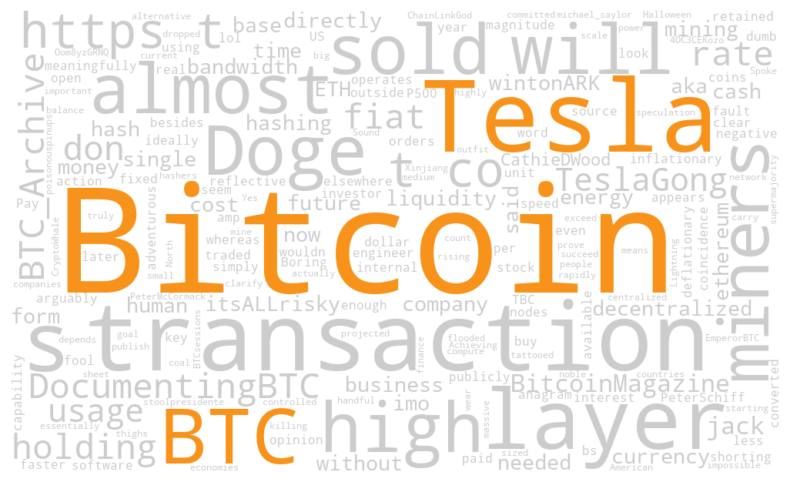

In [79]:
# Define a custom color function with hex codes
from matplotlib import pyplot as plt
from wordcloud import WordCloud


def custom_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    highlight_words = {'Bitcoin', 'Tesla', 'BTC'}
    if word in highlight_words:
        return '#F7931A'  # Highlighted words in red (hex code)
    else:
        return '#CCCCCC'  # Other words in gray (hex code)

# Generate the word cloud with the custom color function
wordcloud = WordCloud(width=1000, height=600, background_color='white', color_func=custom_color_func).generate(all_text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [1]:
import plotly.express as px

# Create a DataFrame from the word counts
word_counts_df = pd.DataFrame.from_dict(word_counts, orient='index').reset_index()
word_counts_df.columns = ['word', 'count']

# Define a custom color function with hex codes
def custom_color_func(word):
    highlight_words = {'Bitcoin', 'Tesla', 'BTC'}
    if word in highlight_words:
        return '#F7931A'  # Highlighted words in red (hex code)
    else:
        return '#CCCCCC'  # Other words in gray (hex code)

# Apply the custom color function to the DataFrame
word_counts_df['color'] = word_counts_df['word'].apply(custom_color_func)

# Create the word cloud figure using Plotly
fig = px.treemap(word_counts_df, path=['word'], values='count', color='color', title='Word Cloud of Musk Tweets about Bitcoin')

# Display the figure
fig.show()


NameError: name 'pd' is not defined

In [93]:
import plotly.express as px

# List of highlighted words
highlighted_words = ['Bitcoin', 'Tesla', 'BTC']

# Count the occurrences of highlighted words in the word_counts_df
highlighted_word_counts = word_counts_df[word_counts_df['word'].isin(highlighted_words)]

# Create the pie chart with explode, shadow, and startangle
fig_pie_highlighted = px.pie(highlighted_word_counts, names='word', values='count', title='Highlighted Words Distribution')

# Update the layout to add explode, shadow, and startangle
fig_pie_highlighted.update_traces(pull=[0, 0.1, 0], marker=dict(line=dict(color='#000000', width=0)), rotation=90)

# Display the pie chart
fig_pie_highlighted.show()

# SENTIMENT ANALYSIS !!!

In [6]:
import pandas as pd
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Load the dataset
tweets_df = pd.read_csv('data/musk_tweets.csv', parse_dates=['Timestamp'])

# Function to calculate sentiment polarity
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Apply the sentiment function to each tweet
tweets_df['Sentiment'] = tweets_df['Tweet'].apply(get_sentiment)

# Display the first few rows with sentiment scores
print(tweets_df[['Timestamp', 'Tweet', 'Sentiment']].head())

# Plot the sentiment over time
fig = px.line(tweets_df, x='Timestamp', y='Sentiment', title='Sentiment Analysis of Musk Tweets Over Time')
fig.show()
# Convert sentiment to binary classification: positive (1) if sentiment > 0, else negative (0)
tweets_df['Sentiment_Class'] = tweets_df['Sentiment'].apply(lambda x: 1 if x > 0 else 0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tweets_df['Tweet'], tweets_df['Sentiment_Class'], test_size=0.2, random_state=42)

# Vectorize the text data
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train a Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_vec, y_train)

# Predict the sentiment class for the test set
y_pred = nb_classifier.predict(X_test_vec)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

          Timestamp                                              Tweet  \
0  01/01/2021 00:58  @PPathole Dojo isn’t needed, but will make sel...   
1  02/01/2021 03:20  @comma_ai Tesla Full Self-Driving will work at...   
2  02/01/2021 12:23  @newscientist Um, we have giant fusion reactor...   
3  02/01/2021 14:51  So proud of the Tesla team for achieving this ...   
4  02/01/2021 14:59  @flcnhvy Tesla is responsible for 2/3 of all t...   

   Sentiment  
0   0.166667  
1   0.175000  
2   0.000000  
3   0.439063  
4   0.150000  


Accuracy: 0.7779632721202003
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.70      0.79       354
           1       0.67      0.89      0.77       245

    accuracy                           0.78       599
   macro avg       0.79      0.80      0.78       599
weighted avg       0.81      0.78      0.78       599



### Trump Episode

what will happen with musk presence in gov?